In [1]:
import pandas, numpy, qnorm, seaborn

In [2]:
import scipy, scipy.signal
import sklearn, sklearn.preprocessing, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.90, 9 * 0.90)})

# user-defined variables

In [4]:
input_dir = '/Users/adrian/research/vigur/data/metabolomics/targeted/'

basic_input_file = 'EC008_ROSA_PMVEC_INTRA_BASIC.xlsx'
positive_input_file = 'EC008_ROSA_PMVEC_INTRA_POS.xlsx'
negative_input_file = 'EC008_ROSA_PMVEC_INTRA_NEG.xlsx'

input_files = [positive_input_file, negative_input_file, basic_input_file]
ion_modes = ['positive', 'negative', 'basic']

# read metadata

In [5]:
path = input_dir + basic_input_file
metadata = pandas.read_excel(input_dir+positive_input_file, sheet_name=0, index_col=1)

new_labels = [element.split('_')[0] for element in metadata.index.values]
rosetta = dict(zip(metadata.index.values, new_labels))
metadata.rename(index=rosetta, inplace=True)
metadata.head()

,Sample,Sample ID,BioReplicate,Timepoint,µM catech,TecRep,TNFalpha,LPS,cell number,LCMS Method,LCMS Analytical Order,LCMS BATCH
Label,,,,,,,,,,,,
Pool1,PMUEC_INTRA_EC008_103,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,1,1
Pool1,PMUEC_INTRA_EC008_104,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,2,1
Pool1,PMUEC_INTRA_EC008_105,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,3,1
Pool2,PMUEC_INTRA_EC008_107,Pool2_pos,-,-,-,-,-,-,-,HILIC_POS_10min,4,1
008-02,PMUEC_INTRA_EC008_109,008-2,1,0,0,2,0,0,80000,HILIC_POS_10min,5,1


# broadly exploring distributions

In [6]:
def pca_plotter(df, info):
    
    new_labels = [element.split('_')[0] for element in df.columns.values]
    rosetta = dict(zip(df.columns.values, new_labels))
    df.rename(columns=rosetta, inplace=True)  

    wdf = df.transpose()
    scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(wdf)
    model = sklearn.decomposition.PCA(n_components=2)
    locations = model.fit_transform(scaled_data)
    explained = model.explained_variance_ratio_
    
    for j in range(len(locations)):
        label = wdf.index[j]
        
        #
        # treatment
        #
        if 'A' in label:
            if metadata.loc[label, 'TNFalpha'] == 10:
                treatment = 'TNF'
            elif metadata.loc[label, 'LPS'] == 10:
                treatment = 'LPS'
            else:
                treatment = 0
        elif 'ool' in label:
            treatment = 'Pool'
        else:
            treatment = metadata.loc[label, 'µM catech']
            
        if treatment == 'TNF':
            the_color = 'tab:green'
        elif treatment == 'LPS':
            the_color = 'skyblue'
        elif treatment == 'Pool':
            the_color = 'gold'; the_marker = 'D'
        elif treatment == 0:
            the_color = 'black'
        elif treatment == 5:
            the_color = 'tab:red'
        else:
            print(treatment)
            raise ValueError('unknown treatment')
    
        #
        # timepoint
        #
        if treatment != 'Pool':
            timepoint = metadata.loc[label, 'Timepoint']
            if timepoint == 0:
                the_marker = 'X'
            elif timepoint == 4:
                the_marker = 'o'
            elif timepoint == 24:
                the_marker = 's'
            else:
                raise ValueError('unknown timepoint')
    
        #
        # replicate
        #
        replicate = metadata.loc[label, 'BioReplicate']
        
        #
        # plot
        # 
        matplotlib.pyplot.scatter(locations[j, 0], locations[j, 1], s=500, c=the_color, marker=the_marker, alpha=2/3, edgecolors='none')
        if the_color == 'gold':
            pass
        else:
            matplotlib.pyplot.text(locations[j, 0], locations[j, 1], replicate, fontsize=8, color='white', ha='center', va='center', weight='bold')
    # legend
    legend_elements = [ 
        matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='skyblue', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),

        matplotlib.lines.Line2D([0], [0], color='white', marker='X', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='s', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='D', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
    ]
    matplotlib.pyplot.legend(legend_elements, 
                             ['control', 'epi:nor', 'TNFa', 'LPS', 'Pool', 't=0', 't=4h', 't=24h', 'Pool'], 
                             ncol=1, loc=1, 
                             bbox_to_anchor=(1.2, 1, 0.1, 0.1))

    matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
    matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
    matplotlib.pyplot.title(ion_modes[i] + info)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    #matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    return None

In [7]:
def luthier(df, label):

    print('building violins...')
    
    conditions = [(0, 0), (0, 4), (5, 4), (0, 24), (5, 24)]
    metabolites = qndf.index
    
    for metabolite in metabolites:
        condition_intensities = []
        for condition in conditions:
            bio_rep_intensities = []
            for biorep in [1, 2, 3]:            
                a = metadata['µM catech'] == condition[0]
                b = metadata['Timepoint'] == condition[1]
                c = metadata['BioReplicate'] == biorep
                rules = a & b & c
                info = metadata[rules]
                labels = [label for label in info.index if '008' in label]
                if len(labels) != 3:
                    raise ValueError('not the appropriate number of elements')
                intensities = qndf.loc[metabolite, labels].values
                bio_rep_intensities.append(intensities)
            condition_intensities.append(bio_rep_intensities)
                
        # plot for a metabolite
        the_colors = ['tab:blue', 'tab:green', 'gold']
        shifts = [-0.05, 0, 0.05]
        violin_data = []
        for i in range(len(condition_intensities)):
            sub_violin = []
            for j in range(len(condition_intensities[i])):
                #print(i, j, condition_intensities[i][j])
                matplotlib.pyplot.plot(i+shifts[j], numpy.median(condition_intensities[i][j]), 'o', alpha=0.5, color=the_colors[j], ms=20, mew=0)
                sub_violin.append(numpy.median(condition_intensities[i][j]))
                for k in range(len(condition_intensities[i][j])):
                    matplotlib.pyplot.plot(i+shifts[j], condition_intensities[i][j][k], 'o', alpha=0.8, color=the_colors[j], ms=5, mew=0)
            violin_data.append(sub_violin)
        seaborn.violinplot(violin_data, color='white', inner=None)
            
        matplotlib.pyplot.xticks([0, 1, 2, 3, 4], ['t = 0 h\n0 um', 't = 4 h\n0 um', 't = 4 h\n5 um', 't = 24 h\n0 um', 't = 24 h\n5 um'])
        matplotlib.pyplot.title('{} {}'.format(metabolite, label))
        matplotlib.pyplot.grid(alpha=1/2, ls=':')
        matplotlib.pyplot.ylabel('log$_2$ Intensity')
        matplotlib.pyplot.xlabel('Condition')
        matplotlib.pyplot.tight_layout()
        
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('figures/{}.{}.png'.format(metabolite, label))
        matplotlib.pyplot.close()

    return None

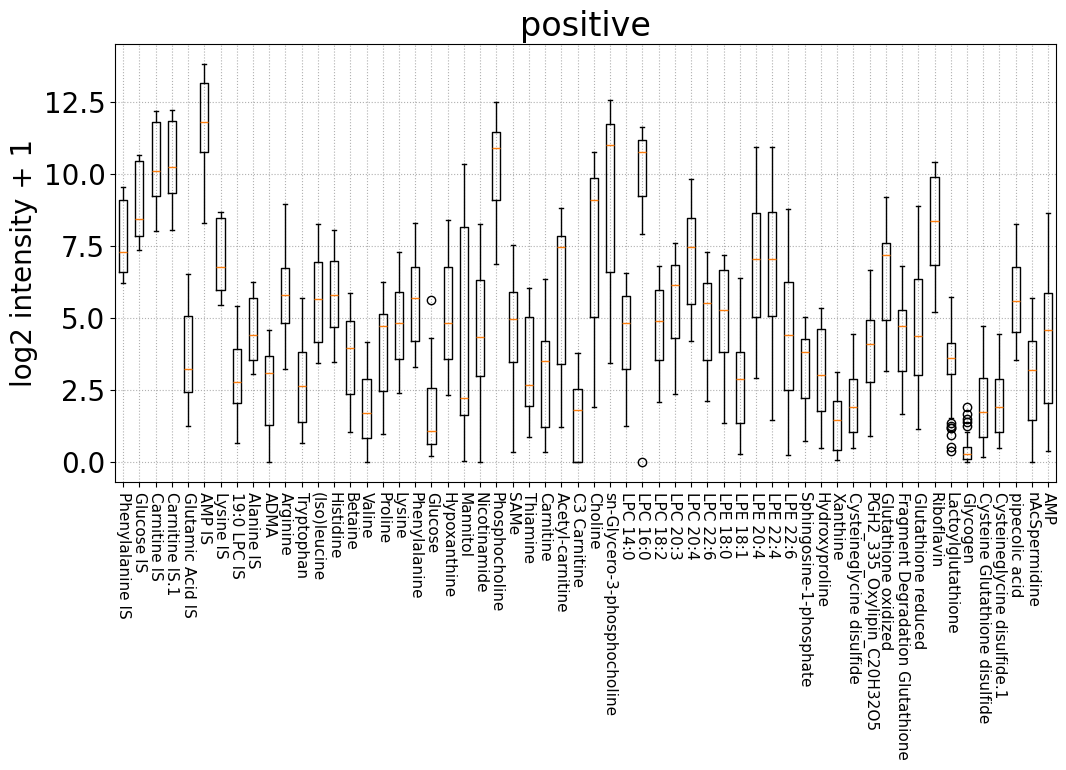

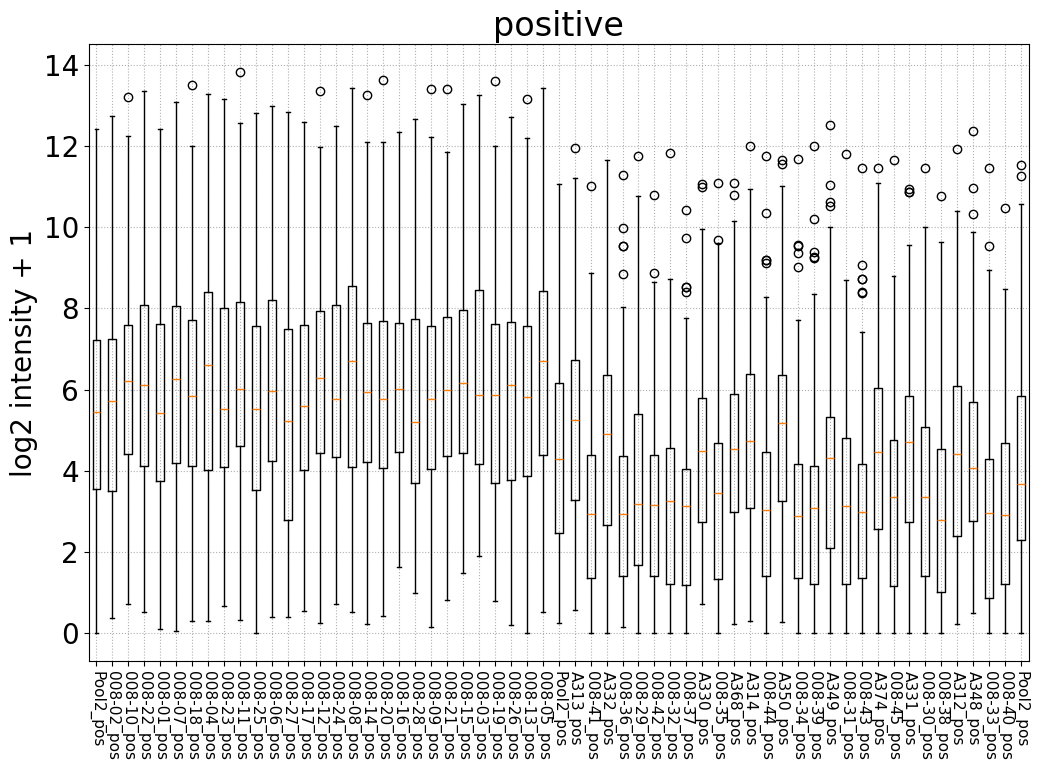

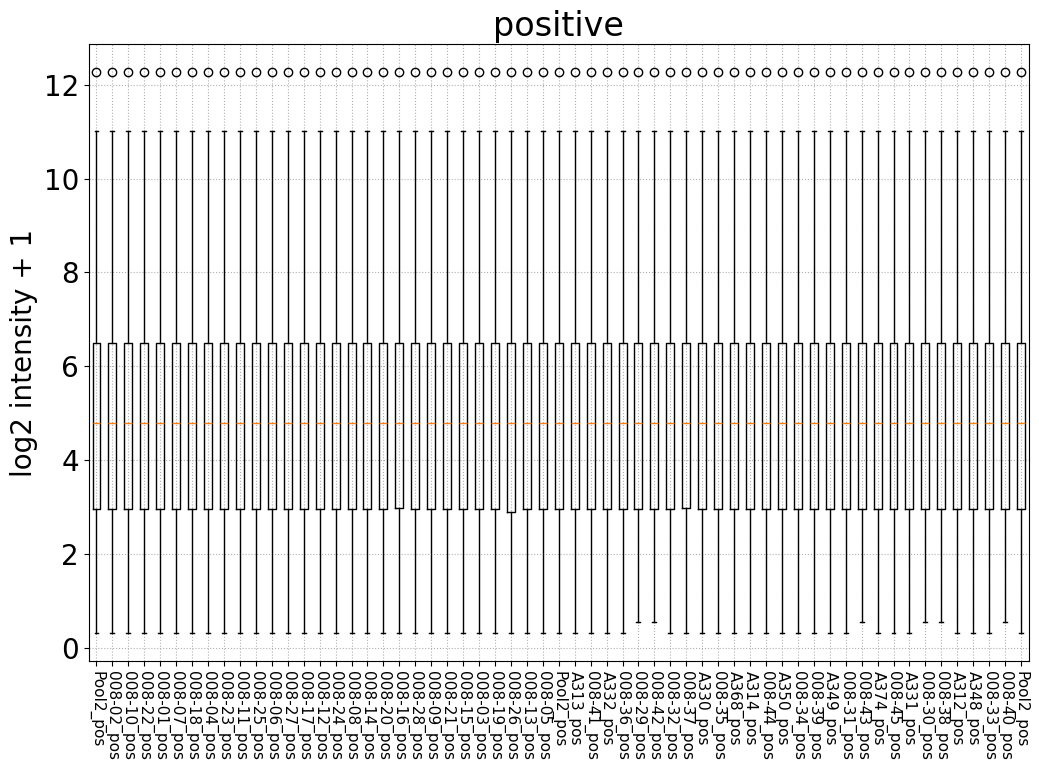

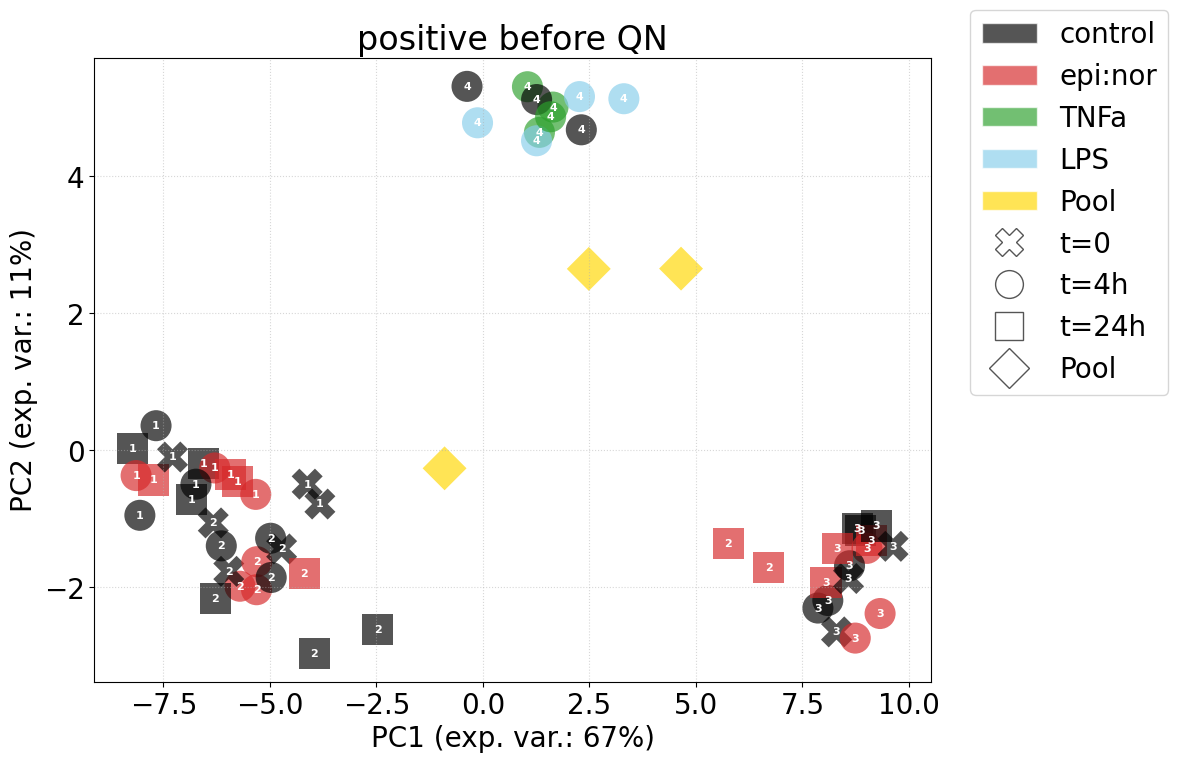

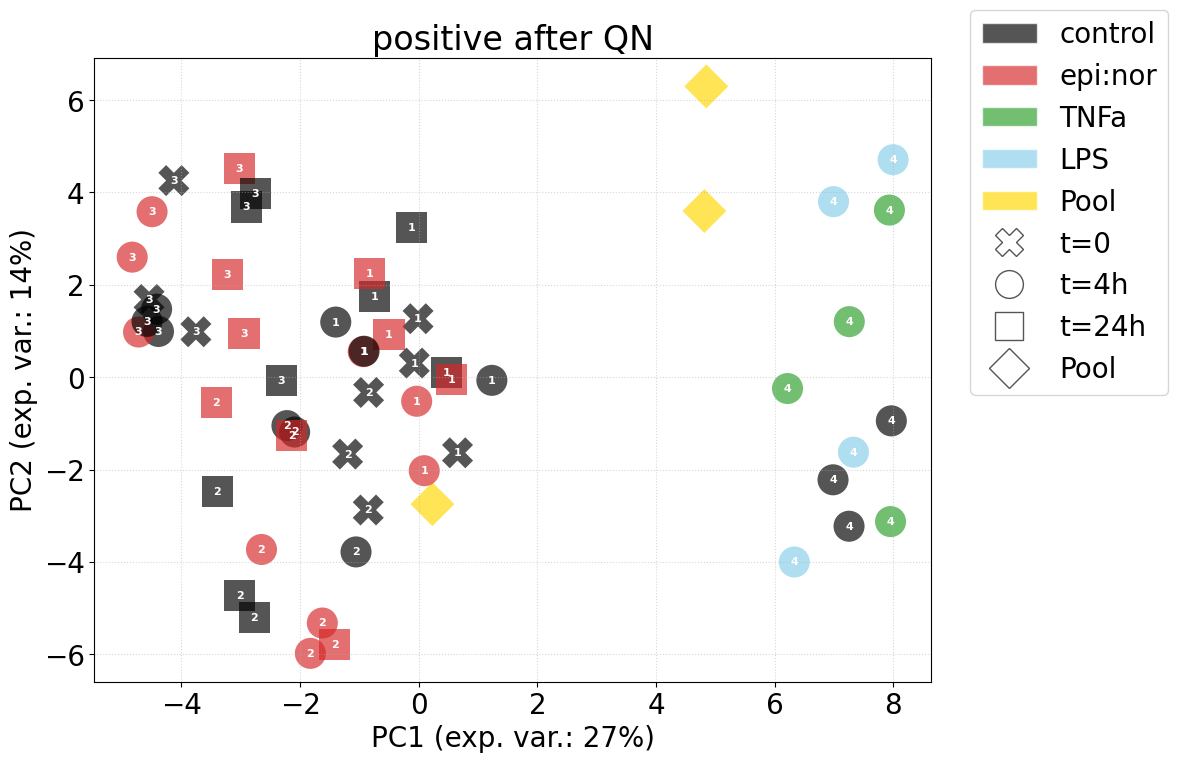

building violins...


FileNotFoundError: [Errno 2] No such file or directory: 'figures/Phenylalanine IS.before QN.png'

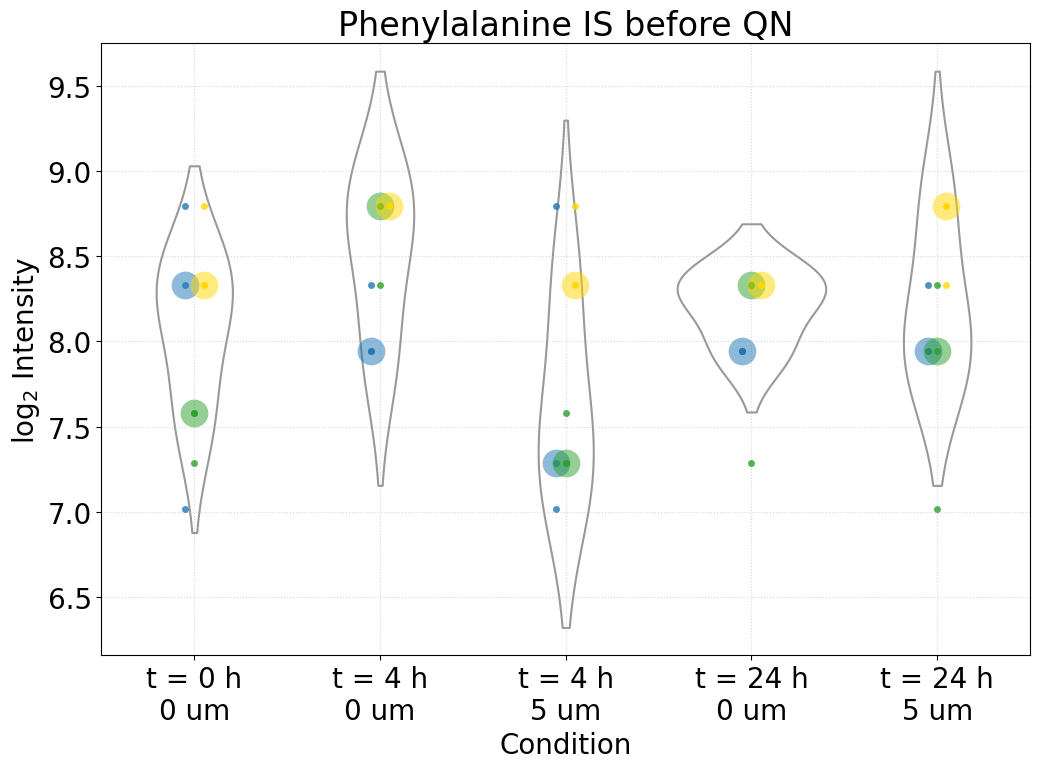

In [8]:
all_dfs = []
for i in range(len(input_files)):

    input_file = input_files[i]
    ion_mode = ion_modes[i]
    
    path = input_dir + input_file
    df = pandas.read_excel(path, sheet_name=1, index_col=0)
    
    log2intensity = numpy.log2(df+1)

    #
    # display metabolite distributions
    #
    matplotlib.pyplot.boxplot(log2intensity)

    matplotlib.pyplot.xticks(range(1,len(df.columns)+1), df.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')

    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # show sample distributions
    #
    log_df = numpy.log2(df+1)
    transpose = log2intensity.transpose()

    matplotlib.pyplot.boxplot(transpose)
    matplotlib.pyplot.xticks(range(1,len(transpose.columns)+1), transpose.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')
    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # perform quantile normalization
    #
    qndf = qnorm.quantile_normalize(transpose, axis=1)
    all_dfs.append(qndf)

    matplotlib.pyplot.boxplot(qndf)
    matplotlib.pyplot.xticks(range(1,len(qndf.columns)+1), qndf.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')
    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # pca
    #
    pca_plotter(transpose, ' before QN')
    pca_plotter(qndf, ' after QN')

    #
    # violin plots
    #
    luthier(transpose, 'before QN')
    luthier(qndf, 'after QN')

The conclusion from these figures is that:
- quantification units are intensities.
- quantification is not quantitative.
- we need quantile normalization.
- Biological replicate and not treatment is the largest source of variation.
- Quantile normalization does not fix previous point.

# visualize metabolites across conditions

## violin plots

In [ ]:
print('all done.')

In [ ]:
# visualize violin plots for each metabolite across all conditions. Do a test on specific conditions.
# subset significant ones for heatmap. Consider one for lipids and another one for metabolites in the manuscript (consider comparing replicate-wise)

In [ ]:
# heatmap